In [1]:
from tools import obj_dic, show_heatmap, show_heatmap_contours
import numpy as np

from scipy.stats import norm, invgamma, beta
import scipy.stats

from matplotlib import pyplot as plt
from IPython.display import display, Markdown

md = lambda *args: display(Markdown(*args))

np.random.seed(12345)

In [2]:
# Generate the Dataset as N draws from a normal distribution with base_mean and base_stdev

base_mean = 4
base_stdev = 1
N = 100
#X = np.random.normal(40, 10, (N, 1))
X = np.random.normal(base_mean, base_stdev, (N, 1))


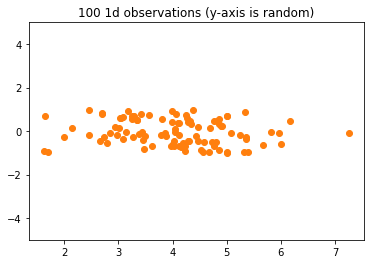

In [3]:
# Look at the data
plt.scatter([],[])
plt.scatter(X[:,0], np.random.uniform(-1, 1, (N)))
plt.ylim(-5, 5)
plt.title(str(N)+" 1d observations (y-axis is random)")
plt.show()



In [4]:
# define a function to compute (on a grid, up to a constant factor) and draw the true posterior p(θ|X)

def plot_true_distribution(contours=True, cmap="gray",
                           minx=base_mean-0.3,
                           maxx=base_mean+0.3,
                           miny=base_stdev/1.3,
                           maxy=base_stdev*1.3,
                           prior=None):
    mm = lambda a: (np.min(a), np.max(a))
    Lprop = lambda μ, σ, X: 1/(2*np.pi*σ**2)**(X.shape[0]/2) * np.exp(- np.sum((X - μ)**2, axis=0, keepdims=True) / (2*σ**2))
    linspaceμ = np.linspace(minx, maxx, 101)
    linspaceσ = np.linspace(miny, maxy, 103)
    Lmap = Lprop(linspaceμ[None,:,None], linspaceσ[None,None,:], X[:,None])
    if prior is not None:
        Lmap *= prior(linspaceμ[:,None], linspaceσ[None,:])
    if contours:
        plt.contour((Lmap[0].T), extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', cmap=cmap)
    else:
        plt.imshow((Lmap[0].T), extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', aspect='auto')
        plt.colorbar()
    return obj_dic(locals())


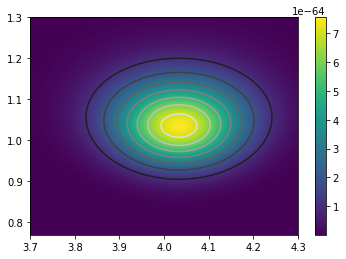

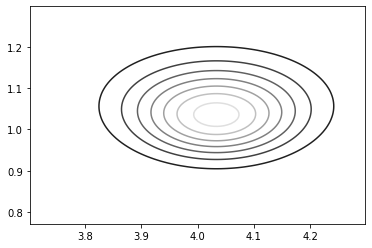

In [5]:
# Show the true posterior

default_plot = plot_true_distribution(False)
plot_true_distribution()
plt.show()
plot_true_distribution()
plt.show()



# GIBBS SAMPLING EXAMPLE

### Running the Gibbs sampler, showing the successive conditional probabilities

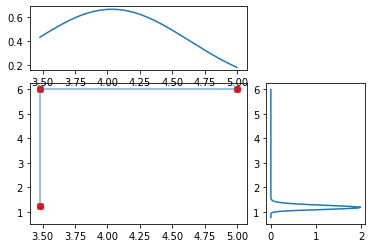

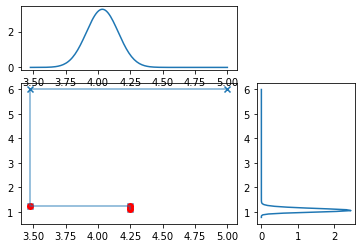

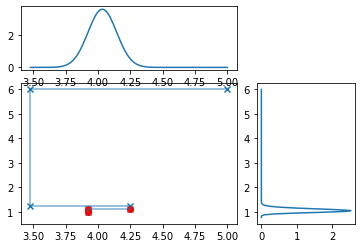

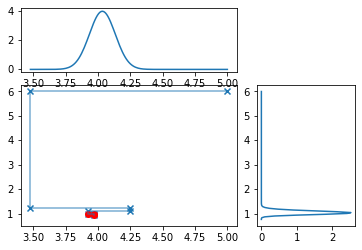

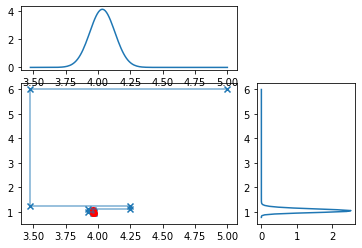

### Plotting after 100 samples

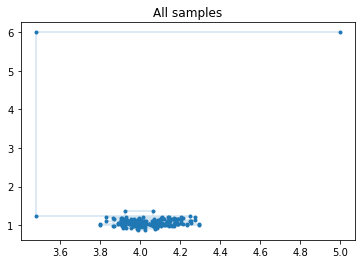

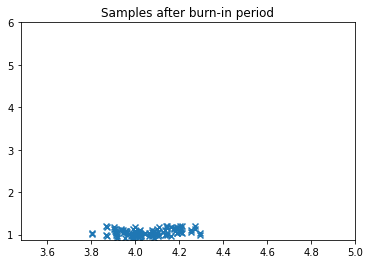

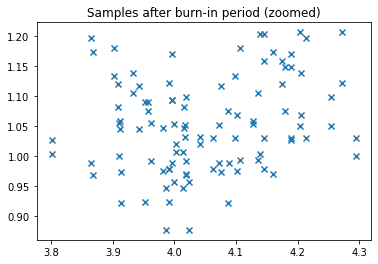

Estimating the p(θ|X) as an histogram from samples (true posterior with lines)


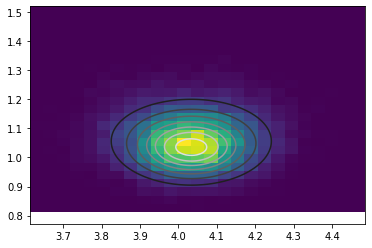

In [6]:


md("# GIBBS SAMPLING EXAMPLE")

def do_gibbs_uninformative_prior():
    μ = 5  ####### GIBBS: initialize
    σ = 6  ####### GIBBS: initialize

    μs = [μ]
    σs = [σ]

    ITER = 20000 #*100
    BURN = 100
    PLOT_AT = [200 // 2]
    PLOT_NICE_AT = [0, 1, 2, 3, 4]
    md('### Running the Gibbs sampler, showing the successive conditional probabilities')
    for i in range(ITER//2):  ####### GIBBS: loop
        
        # scipy normal distribution uses the standard deviation
        μ = norm.rvs(np.mean(X), σ / N**0.5)  ####### GIBBS: one step
        μs.append(μ)
        σs.append(σ)
        
        σ = invgamma.rvs(N/2 - 1, 0, np.sum((X-μ)**2)/2) ** 0.5  ####### GIBBS: another step
        μs.append(μ)
        σs.append(σ)
        
        if i in PLOT_NICE_AT:
            minx = min(base_mean-0.3, np.min(μs))
            maxx = max(base_mean+0.3, np.max(μs))
            miny = min(base_stdev/1.3, np.min(σs))
            maxy = max(base_stdev*1.3, np.max(σs))
            ax = plt.subplot(3, 3, (4,8))
            plt.plot(μs, σs, alpha=0.6)
            plt.scatter(μs, σs, marker='x')
            
            plt.subplot(3, 3, (1,2), sharex=ax)
            x = np.linspace(minx, maxx, 151)
            plt.plot(x, norm.pdf(x, np.mean(X), σs[-3] / N**0.5))

            plt.subplot(3, 3, (6,9), sharey=ax)
            x = np.linspace(miny, maxy, 151)
            plt.plot(invgamma.pdf(x**2, N/2 - 1, 0, np.sum((X-μs[-2])**2)/2), x)

            ax.scatter(μs[-3:], σs[-3:], c='r')
            plt.show()
        if i in PLOT_AT:
            md('### Plotting after '+str(i)+' samples')
            plt.plot(μs, σs, alpha=0.2)
            plt.scatter(μs, σs, marker='.')
            plt.title('All samples')
            plt.show()

            plt.scatter(μs[BURN:], σs[BURN:], marker='x')
            plt.xlim(np.min(μs), np.max(μs))
            plt.ylim(np.min(σs), np.max(σs))
            plt.title('Samples after burn-in period')
            plt.show()
            
            plt.scatter(μs[BURN:], σs[BURN:], marker='x')
            plt.title('Samples after burn-in period (zoomed)')
            plt.show()


    print('Estimating the p(θ|X) as an histogram from samples (true posterior with lines)')
    show_heatmap(μs[BURN:], σs[BURN:], bins=25)
    plot_true_distribution()
    plt.show()
    return obj_dic(locals())

gibbs = do_gibbs_uninformative_prior()


# METROPOLIS-HASTINGS EXAMPLE

## Showing accepted samples and rejected samples (1 chain)

### No prior

<ipython-input-7-eb71c3234378>:42: RuntimeWarning: overflow encountered in exp
  paccept = np.exp(lnLratio(μnew, σnew, μ, σ)) # no prior


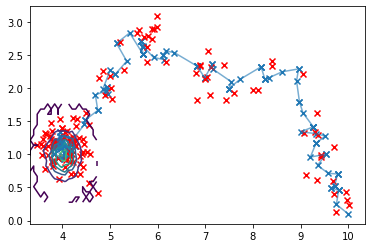

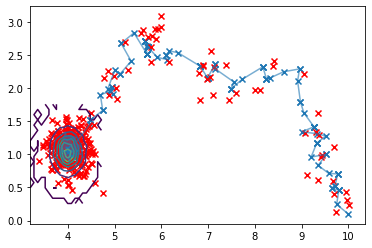

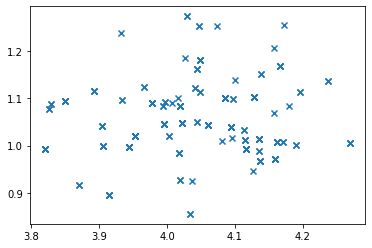

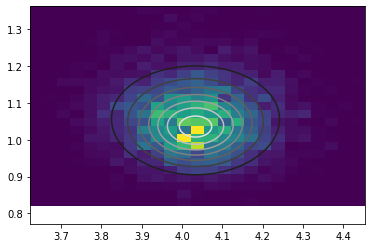

Accepted 4947 and rejected 15054

### Prior that biases the estimate

<ipython-input-7-eb71c3234378>:12: RuntimeWarning: invalid value encountered in log
  lnLproportional = lambda μ, σ: -(X.shape[0]*np.log(σ) + np.sum((X - μ)**2)/2/σ**2) # up to log((2π)^½N)
<ipython-input-7-eb71c3234378>:35: RuntimeWarning: overflow encountered in exp
  paccept = np.exp(


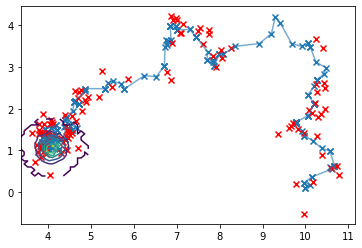

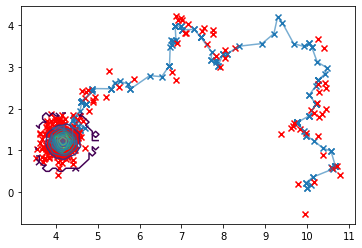

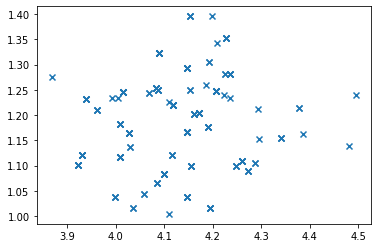

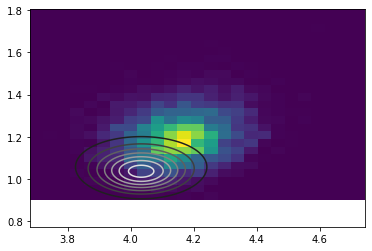

Accepted 6253 and rejected 13748

### Prior that forbids σ > 2.5

Funky


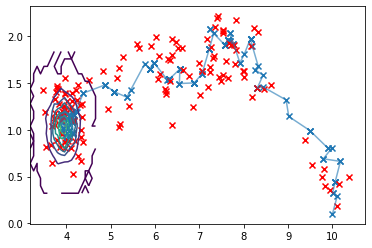

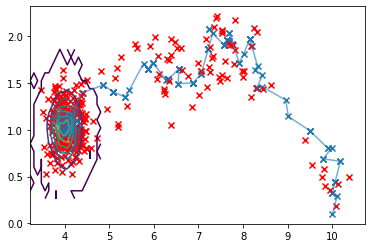

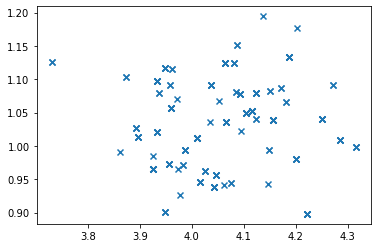

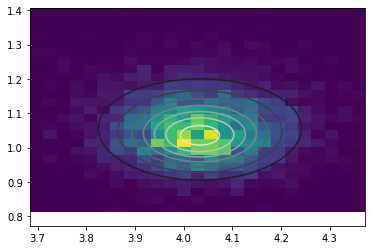

Accepted 4980 and rejected 15021

## Draw a few chains

Accepted 207 and rejected 294

Accepted 155 and rejected 346

Accepted 188 and rejected 313

Accepted 150 and rejected 351

Accepted 176 and rejected 325

Accepted 195 and rejected 306

Accepted 188 and rejected 313

Accepted 134 and rejected 367

Accepted 146 and rejected 355

Accepted 189 and rejected 312

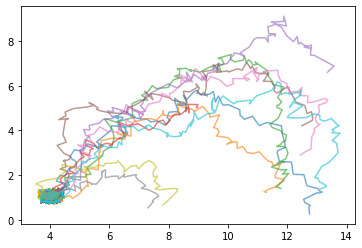

Accepted 196 and rejected 305

Accepted 193 and rejected 308

Accepted 163 and rejected 338

Accepted 174 and rejected 327

Accepted 202 and rejected 299

Accepted 166 and rejected 335

Accepted 183 and rejected 318

Accepted 165 and rejected 336

Accepted 174 and rejected 327

Accepted 161 and rejected 340

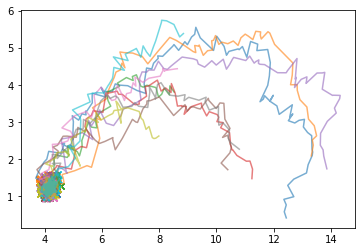

Funky


Accepted 150 and rejected 351

Funky


Accepted 148 and rejected 353

Funky


Accepted 132 and rejected 369

Funky


Accepted 140 and rejected 361

Funky


Accepted 137 and rejected 364

Funky


Accepted 122 and rejected 379

Funky


Accepted 130 and rejected 371

Funky


Accepted 138 and rejected 363

Funky


Accepted 134 and rejected 367

Funky


Accepted 170 and rejected 331

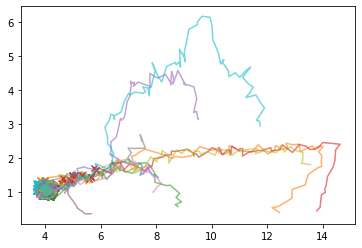

In [7]:
md('# METROPOLIS-HASTINGS EXAMPLE')

def do_metropolis_hastings(prior=False, show=True, ITER=20000, INIT=(10,0.1)):
    μ, σ = INIT ####### METROPOLIS-HASTINGS: initialize

    μs = [μ]
    σs = [σ]
    rej_μs = []
    rej_σs = []

    # log likelihood function
    lnLproportional = lambda μ, σ: -(X.shape[0]*np.log(σ) + np.sum((X - μ)**2)/2/σ**2) # up to log((2π)^½N)
    lnLratio = lambda μn, σn, μ, σ: lnLproportional(μn, σn) - lnLproportional(μ, σ) # log(a/b) = log(a) - log(b)
    # log prior function
    # NB: non-conjugate prior, we have no contraint here
    lnprior = lambda μ, σ: -(μ-5)**2/.2 + -(σ-3)**2/.2  # kind of gaussian prior around μ=5, σ=2, pretty tight, so we see that even with 100 observations the prior impacts significantly what is the optimal p(μ,σ|X)
    
    if prior == "Funky": # softly "forbid" a region to force the sample to get around it
        # a improper prior that is almost 0 if σ≥2.5, and transitions to 1 at σ=1.5
        # the 100 is the importance of the prior compared to the data term lnLproportional
        lnprior = lambda μ, σ: 100*np.log(np.clip(2.5 - σ, 0.0001, 1))
        print("Funky")
        # warning: we could create bad local optimum with the prior, which can cause a lot of rejected samples
    
    BURN = 200
    PLOT_AT = [200, 400]
    if not show:
        PLOT_AT = [ITER-1]
        
    for i in range(ITER): ####### METROPOLIS-HASTINGS: loop
        μσvar = .2
        μnew, σnew = norm.rvs(μ, μσvar), norm.rvs(σ, μσvar) # using a proposal distribution that is a normal around the current parameters
        
        if prior is not False:
            paccept = np.exp(
                lnLproportional(μnew, σnew) - lnLproportional(μ, σ)
                + lnprior(μnew, σnew) - lnprior(μ, σ) # prior
            ) ####### METROPOLIS-HASTINGS: compute acceptance "probability" (might be > 1)
        else:
            #paccept = L(μnew, σnew, X) / L(μ, σ, X) # no prior, not numerically stable
            #paccept = np.exp( lnLproportional(μnew, σnew) - lnLproportional(μ, σ)   )  # no prior
            paccept = np.exp(lnLratio(μnew, σnew, μ, σ)) # no prior
        
        if np.random.uniform(0, 1) < paccept: ####### METROPOLIS-HASTINGS: draw the acceptance
            μ, σ = μnew, σnew ####### METROPOLIS-HASTINGS: accepted
        else:
            rej_μs.append(μnew)
            rej_σs.append(σnew)
        μs.append(μ)
        σs.append(σ)

        if i in PLOT_AT:
            plt.plot(μs, σs, alpha=0.6)
            if show:
                plt.scatter(μs, σs, marker='x')
                plt.scatter(rej_μs, rej_σs, marker='x', c='r')
                show_heatmap_contours(norm.rvs(μ, μσvar, 10000), norm.rvs(σ, μσvar, 10000))
                plt.show()
            if i > BURN:
                plt.scatter(μs[BURN:], σs[BURN:], marker='x')
                if show:
                    plt.show()
            
    if show:
        show_heatmap(μs[BURN:], σs[BURN:], bins=25)
        plot_true_distribution()
        plt.show()
    md("Accepted " + str(len(μs)-len(rej_μs)) + " and rejected " + str(len(rej_μs)))
    return obj_dic(locals())


md("## Showing accepted samples and rejected samples (1 chain)")
md("### No prior")
mh = do_metropolis_hastings()
md("### Prior that biases the estimate")
mh = do_metropolis_hastings(True)
md("### Prior that forbids σ > 2.5")
mh = do_metropolis_hastings("Funky")


md("## Draw a few chains")
for setup in [False, True, 'Funky']:
    for i in range(10):
        do_metropolis_hastings(setup, show=False, ITER=500, INIT=(norm.rvs(10, 2), np.abs(norm.rvs(1, 2))))
    plt.show()


# VARIATIONAL INFERENCE EXAMPLE

## Not too bad prior and initialization

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

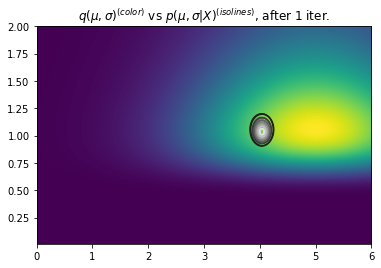

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

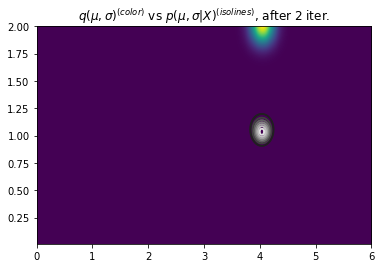

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

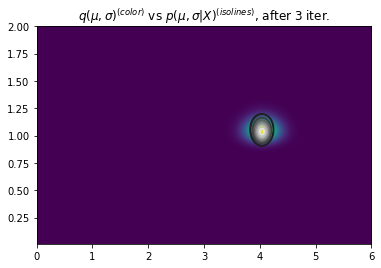

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

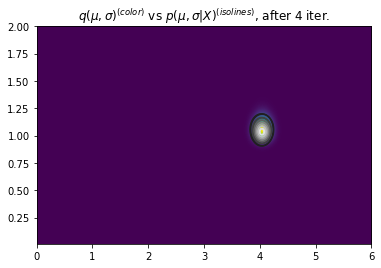

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

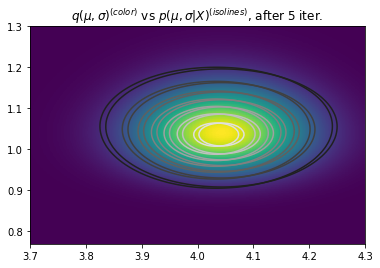

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

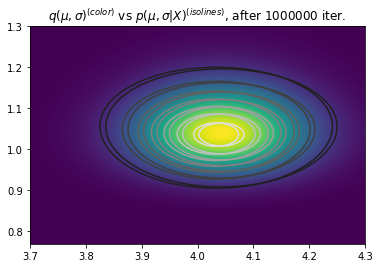

Plotting the mean of the estimate accross iterations (we see a convergence)

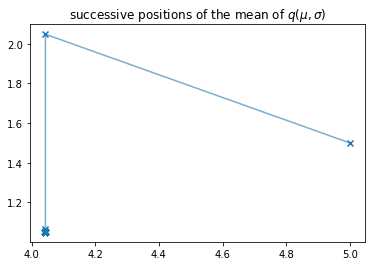

## Poor prior and initialization

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

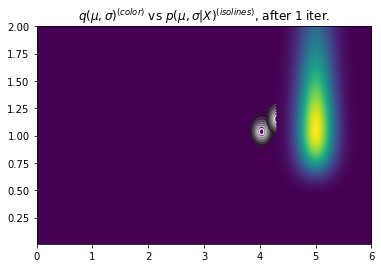

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

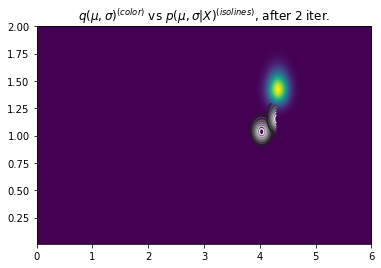

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

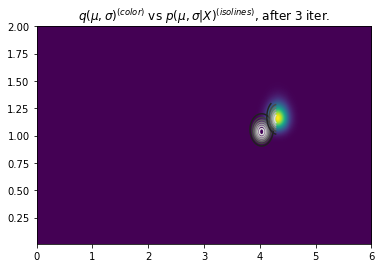

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

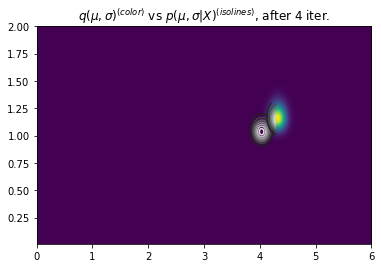

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

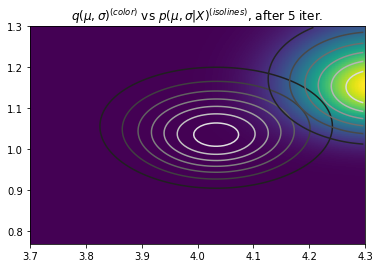

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

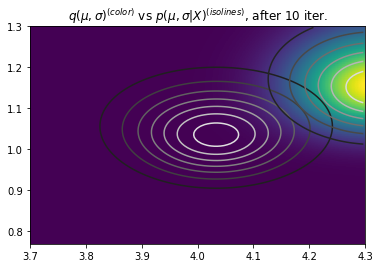

Plotting the mean of the estimate accross iterations (we see a convergence)

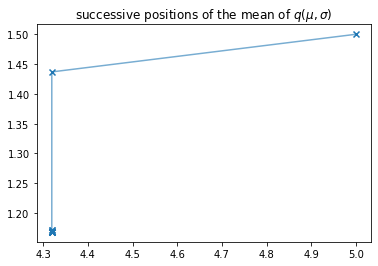

## Fuzzy prior and initialization

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

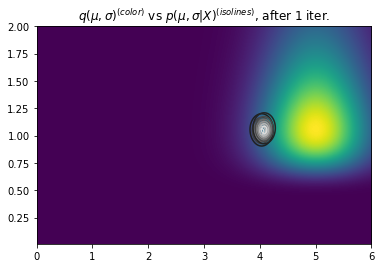

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

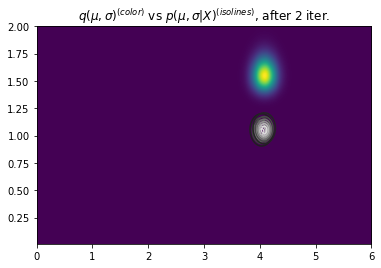

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

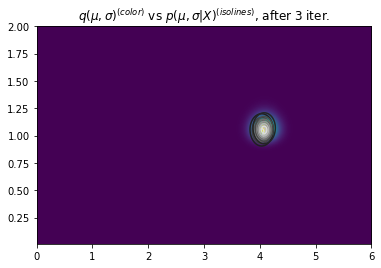

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

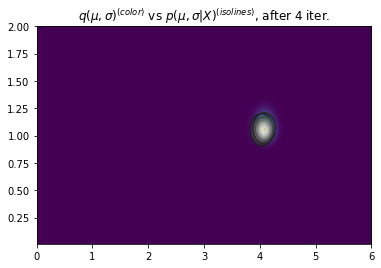

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

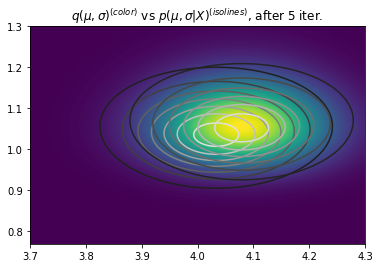

Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)

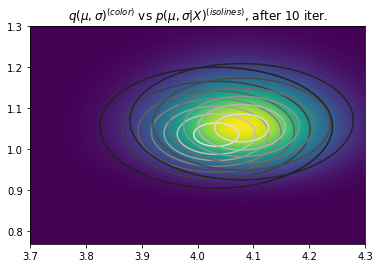

Plotting the mean of the estimate accross iterations (we see a convergence)

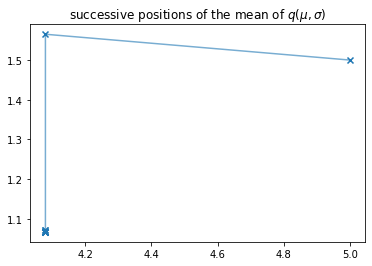

CPU times: user 8.76 s, sys: 157 ms, total: 8.92 s
Wall time: 8.98 s


In [8]:
%%time
md('# VARIATIONAL INFERENCE EXAMPLE')

def do_variational_inference(PRIOR=(5,1 , 1,1.5**2), ITER=1000000):
    µ0, λ0, α0, β0 = PRIOR ####### VARIATIONAL INFERENCE: prior
    
    ####### VARIATIONAL INFERENCE:  set inital values of the variational parameters using the prior
    μN = µ0
    σN = (β0/α0/λ0)**0.5
    αN = α0
    βN = β0

    ####### VARIATIONAL INFERENCE: constants
    Xsum = np.sum(X)
    X2sum = np.sum(X**2)
    #print(Xsum, X2sum, N)

    history = []
    history.append([μN,σN,αN,βN])

    PLOT_AT = [ITER-1]
    PLOT_PDF_AT = [0, 1, 2, 3, 4, ITER-1]
    PLOT_BROAD =  [0, 1, 2, 3]
    for i in range(ITER): ####### VARIATIONAL INFERENCE: loop
        # actually it is all at the same time
        αN,βN,μN,σN = (
            α0 + (N+1)/2,
            β0 + 0.5 * ( (λ0+N)*(σN**2+μN**2) - 2*(μ0*λ0+Xsum)*μN + X2sum + λ0*μ0**2 ),
            (Xsum + λ0*μ0) / (N + λ0),
            (βN/αN/(N+λ0))**0.5,
        ) ####### VARIATIONAL INFERENCE: closed form deterministic update
        history.append([μN,σN,αN,βN])

    for i in sorted(list(set(PLOT_AT + PLOT_PDF_AT))):
        μN,σN,αN,βN = history[i]
        if i in PLOT_PDF_AT:
            md('Current variational estimation q(θ) (heatmap) vs true posterior p(θ|X) (isolines) (and also without prior)')
            linspaceμ = default_plot.linspaceμ
            linspaceσ = default_plot.linspaceσ
            if i in PLOT_BROAD:
                linspaceμ = np.linspace(0, 6, 303)
                linspaceσ = np.linspace(0.01, 2, 301)
            pσ = invgamma.pdf(linspaceσ**2, αN, 0, βN)
            pμ = norm.pdf(linspaceμ[:,None], μN, σN)
            pμσ = pμ*pσ[None,:]

            mm = default_plot.mm
            plt.imshow(pμσ.T, extent=[*mm(linspaceμ), *mm(linspaceσ)], origin='lower', aspect='auto')
            #plt.colorbar()
            plot_true_distribution()
            plot_true_distribution(prior=lambda μ,σ: invgamma.pdf(σ**2, α0, 0, β0) * norm.pdf(μ, μ0, σ/λ0**0.5))
            plt.title("$q(\\mu, \\sigma)^{(color)}$ vs $p(\\mu, \\sigma | X)^{(isolines)}$, after "+str(i+1)+" iter.")
            plt.show()
 
        if i in PLOT_AT:
            md('Plotting the mean of the estimate accross iterations (we see a convergence)')
            h = np.array(history)
            μs = h[:,0]
            σs = (h[:,3]/h[:,2])**0.5
            plt.title("successive positions of the mean of $q(\\mu, \\sigma)$")
            plt.plot(μs, σs, alpha=0.6)
            plt.scatter(μs, σs, marker='x')
            plt.show()

    return obj_dic(locals())

md('## Not too bad prior and initialization')
vi = do_variational_inference()
md('## Poor prior and initialization')
# 42 virtual points at value 5, 
vi = do_variational_inference(PRIOR=(5,42 , 1,1.5**2), ITER=10)
md('## Fuzzy prior and initialization')
# 5 points at 5
vi = do_variational_inference(PRIOR=(5,5 , 1,1.5**2), ITER=10)